In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.node_num = 12
        self.learning_rate = 0.001
        self.epochs_cnt = 5
        self.model = self.build_model()        
        
        self.discount_rate = 0.97
        self.penalty = -100
        
        self.episode_num = 500        
        
        self.replay_memory_limit = 2048
        self.replay_size = 32 
        self.replay_memory = []

        self.epsilon = 0.99
        self.epsilon_decay = 0.2
        self.epsilon_min = 0.05
        
        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []        

    def build_model(self):
        input_states = Input(shape=(self.state_size,), name='input_states')
        x = Dense(self.node_num, activation='tanh')(input_states)
        out_actions = Dense(self.action_size, activation='linear', name='output')(x)

        model = tf.keras.models.Model(inputs=input_states, outputs=out_actions)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='mean_squared_error')
        model.summary()
        return model   

    def train(self):
        for episode in range(self.episode_num):
            state, _ = self.env.reset()
            
            _, step_count, reward_tot = self.take_action_and_append_memory(episode, state)
            
            self.reward_list.append(reward_tot - self.penalty)
            self.count_list.append(step_count)
            self.moving_avg_list.append(np.mean(self.reward_list[-self.moving_avg_size:]))                
            
            self.train_mini_batch()
                
            if episode % 10 == 0:
                moving_avg = np.mean(self.reward_list[-self.moving_avg_size:])
                reward_avg = np.mean(self.reward_list)
                print(f"episode:{episode}, moving_avg:{moving_avg:.2f}, rewards_avg:{reward_avg:.2f}")
        
        self.save_model()

    def take_action_and_append_memory(self, episode, state):
        reward_tot = 0
        step_count = 0
        done = False
        epsilon = self.get_episilon(episode)

        while not done:
            step_count += 1
            state_input = np.reshape(state, [1, self.state_size]).astype(np.float32)
            Q = self.model(state_input).numpy()
            action = self.greed_search(epsilon, Q)

            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            if done and step_count < 499:
                reward = self.penalty

            self.replay_memory.append([state, action, reward, next_state, done])
            if len(self.replay_memory) > self.replay_memory_limit:
                self.replay_memory.pop(0)

            reward_tot += reward
            state = next_state

        return Q, step_count, reward_tot

    def train_mini_batch(self):
        if len(self.replay_memory) < self.replay_size:
            return

        batch = rand.sample(self.replay_memory, self.replay_size)

        array_state = np.zeros((self.replay_size, self.state_size), dtype=np.float32)
        array_next_state = np.zeros((self.replay_size, self.state_size), dtype=np.float32)

        actions, rewards, dones = [], [], []

        for idx, (state, action, reward, next_state, done) in enumerate(batch):
            array_state[idx] = state
            array_next_state[idx] = next_state
            actions.append(action)
            rewards.append(reward)
            dones.append(done)

        q_values = self.model(array_state).numpy()
        q_next_values = self.model(array_next_state).numpy()

        for idx in range(self.replay_size):
            if dones[idx]:
                q_values[idx, actions[idx]] = rewards[idx]
            else:
                q_values[idx, actions[idx]] = rewards[idx] + self.discount_rate * np.max(q_next_values[idx])

        self.train_on_batch(array_state, q_values)

    def train_on_batch(self, states, targets):
        with tf.GradientTape() as tape:
            predictions = self.model(states, training=True)
            loss = tf.reduce_mean(tf.square(targets - predictions))
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))        

    def get_episilon(self, episode):
        
        result = self.epsilon * (1 - episode / (self.episode_num * self.epsilon_decay))
        
        return max(result, self.epsilon_min)

    def greed_search(self, epsilon, Q):
        
        if epsilon > np.random.rand():
            return self.env.action_space.sample()
        
        else:
            return np.argmax(Q)

    def save_model(self):
        os.makedirs("./model", exist_ok=True)
        self.model.save("./model/dqn.keras")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 12)                60        
                                                                 
 output (Dense)              (None, 2)                 26        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
episode:0, moving_avg:12.00, rewards_avg:12.00
episode:10, moving_avg:19.18, rewards_avg:19.18
episode:20, moving_avg:20.60, rewards_avg:20.19
episode:30, moving_avg:25.00, rewards_avg:22.94
episode:40, moving_avg:26.50, rewards_avg:23.27
episode:50, moving_avg:28.35, rewards_avg:25.06
episode:60, moving_avg:28.65, rewards_avg:

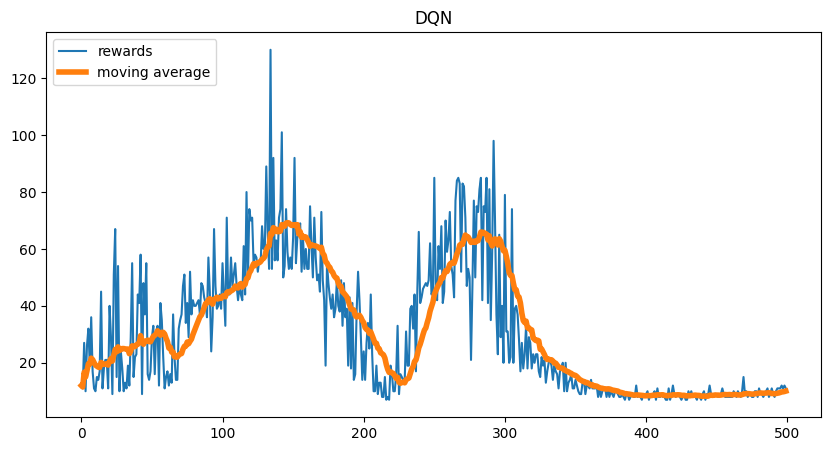

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('DQN')
plt.show()

AttributeError: 'Agent' object has no attribute 'loss'

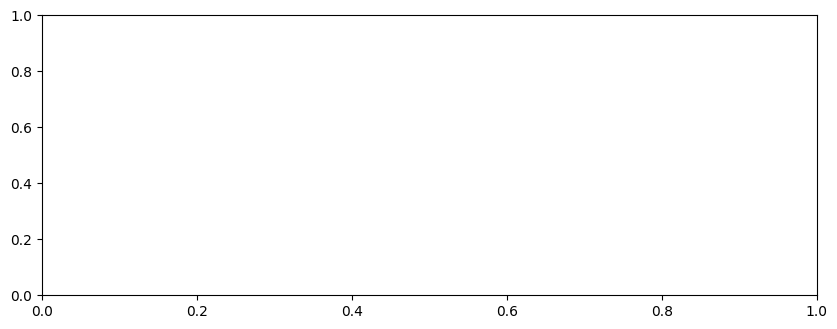

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.subplot(211) #numrows, numcols, plot_number
plt.plot(agent.loss)
plt.title('loss')

plt.subplot(212) #numrows, numcols, plot_number
plt.plot(agent.reward_list)
plt.title('reword')

Text(0.5, 1.0, 'reword')

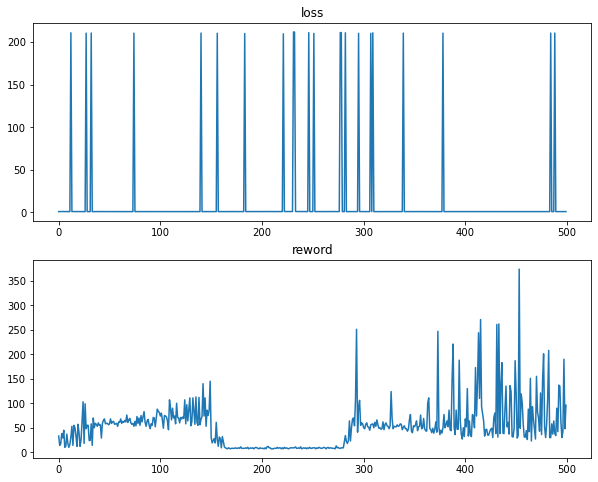

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.subplot(211) #numrows, numcols, plot_number
plt.plot(agent.loss)
plt.title('loss')

plt.subplot(212) #numrows, numcols, plot_number
plt.plot(agent.reward_list)
plt.title('reword')

In [341]:
import tensorflow.keras.backend as K
# y_pred = np.array([[0.6,0.4]])
# c = tf.random.stateless_categorical(tf.math.log(y_pred), 2)
# d = tf.cast(tf.random.stateless_categorical(tf.math.log(y_pred), 2), tf.float32)
# print("c,d", c,d)
# val = np.random.random((3, 4, 5))
# var = K.variable(value=val)
a = K.variable(value=np.array([[1,2],[3,4],[5,6]]))
b = K.variable(value=np.array([[2,2],[4,4],[6,6]]))
c = K.variable(value=np.array([[0.9, 0.1]]))

e = np.array(a)
# d = K.sum(a+b, axis=0)
# e=tf.random.categorical(tf.math.log(c), 2)
# d = np.random.choice(2, 1, p=c)
# y_pred = K.variable(value=[[0.4, 0.6]])
# y_pred_matrixs=tf.random.categorical(tf.math.log(y_pred), 2)
# print(y_pred_matrixs)
f = tf.keras.backend.random_binomial(shape=[1,1], p=c)
f

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [185]:
k=1
w = K.variable(value=np.array([[0.5, 0.5]]))
cum_dist = tf.math.cumsum(w)
cum_dist /= cum_dist[-1]  # to account for floating point errors
unif_samp = tf.random.uniform((k,), 0, 1)
idxs = tf.searchsorted(cum_dist, unif_samp)
samp = tf.gather(a, idxs)  # samp contains the k weighted samples
samp

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 2.]], dtype=float32)>

In [292]:
a = [0.1, 0.9]
choice_indices = K.random_uniform([1,1], minval=0, maxval=1, dtype=tf.int32)
print("*choice_indices:", choice_indices)
samples = tf.gather([0.6, 0.4], 1, axis=-1)
print("*samples:", samples)


*choice_indices: tf.Tensor([[0]], shape=(1, 1), dtype=int32)
*samples: tf.Tensor(0.4, shape=(), dtype=float32)


In [451]:
t = tf.random.categorical(tf.math.log([[0.3, 0.7]]), 1)
u = tf.gather([0.3, 0.7], t, axis=-1)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7]], dtype=float32)>

In [14]:
LOSS_CLIPPING = 1
advantages = [1,2,3,4,5]
advantages = [2,3,4,5,6]
c = -K.minimum(r*advantages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)*advantages)
c

NameError: name 'K' is not defined

In [3]:
!pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.2 MB/s eta 0:00:07
   ----- ---------------------------------- 1.0/8.1 MB 1.7 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/8.1 MB 1.8 MB/s eta 0:00:04
   --------- ------------------------------ 1.8/8.1 MB 1.8 MB/s eta 0:00:04
   ----------- ---------------------------- 2.4/8.1 MB 1.9 MB/s eta 0:00:04
   ----------- ---------------------------- 2.4/8.1 MB 1.9 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/8.1 MB 1.7 MB/s eta 0:00:04
   --------------- ------------------------ 3.1/8.1 MB 1.7 MB/s eta 0:00:03
   ------------------- -------------------- 3.9/8.1 MB 1.9 MB/s eta 0:00:03
   -------------------- ------------------- 4.2/8.1 MB 1.9 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 1.9 MB/s eta 0:00:02
   -----------------------